Plot simulated data for noisy guide efficiencies and results of applying GLiMMIRS-base to these simulated data (Fig. S2).

In [1]:
library(ggplot2)
library(patchwork)
library(ggpubr)
library(rhdf5)
suppressMessages(library(dplyr))
# Change plot size to BIG
options(repr.plot.width=10, repr.plot.height=5)

# Load simulated data for baseline model

In [2]:
fh <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_2guides_discrete_and_continuous_06-20-2024/sim.h5"
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_GROUP,,
2,/counts,continuous,H5I_DATASET,INTEGER,13000 x 50000
3,/counts,discrete,H5I_DATASET,INTEGER,13000 x 50000
4,/,guides,H5I_GROUP,,
5,/guides,metadata,H5I_DATASET,COMPOUND,2000
6,/guides,noisy_guide_efficiencies,H5I_DATASET,COMPOUND,2000
7,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
8,/,linear_predictor,H5I_GROUP,,


In [3]:
noisy.guide.eff <- h5read(fh, 'guides/noisy_guide_efficiencies')

# Replot noisy guide efficiencies with patchwork

In [4]:
head(noisy.guide.eff)

,1,10,100,guide,true
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.7474287,0.7178780,0.6588848,1,0.7112402
2,0.9999318,0.7166597,0.8768369,2,0.8661591
3,0.9946321,0.9665521,0.6918846,3,0.7028934
4,0.1000000,0.4350748,0.4931003,4,0.5348091
5,0.4973153,0.4828629,0.5473952,5,0.5181198
6,0.9999805,0.6370441,0.8182293,6,0.8430382


In [12]:
noisy.df.hist <- noisy.guide.eff %>% tidyr::pivot_longer(!guide, names_to = "D", values_to = "efficiency")

group.colors <- c(`1` = "#DABFFF", `10` = "#907AD6", `100` ="#4F518C", `true` = "#F0EC57")

est.efficiencies.hist.p <- ggplot(noisy.df.hist,
                                aes(x = efficiency, fill = D, color = D)) + 
                            geom_histogram(position = "dodge", alpha = 0.5) + 
                            theme_classic() + 
                            theme(text = element_text(size = 22)) + 
                            scale_fill_manual(values=group.colors) + 
                            scale_color_manual(values = group.colors) + xlim(0,1)

noisy.df.scatter <- noisy.guide.eff %>% tidyr::pivot_longer(cols = as.character(c(1,10,100)), names_to = "D", values_to = "noisy")


est.efficiencies.scatter.p <- ggplot(noisy.df.scatter, aes(x = true, y = noisy, col = D)) + geom_point() + 
                                        theme_classic() + 
                                        theme(text = element_text(size = 20)) + 
                                        scale_fill_manual(values=group.colors[1:3]) + 
                                        scale_color_manual(values = group.colors[1:3]) + xlim(0,1) + ylim(0,1)

In [13]:
# calculate Pearson r between true vs. noisy efficiencies 
noisy.df.scatter %>% group_by(D) %>% summarise(pearson.r = cor.test(true, noisy, method = "pearson")$estimate,
                                            p_val = cor.test(true, noisy, method = "pearson")$p.value)

D,pearson.r,p_val
<chr>,<dbl>,<dbl>
1,0.3914056,3.248538e-74
10,0.7161033,2.585396e-314
100,0.9559148,0.000000e+00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


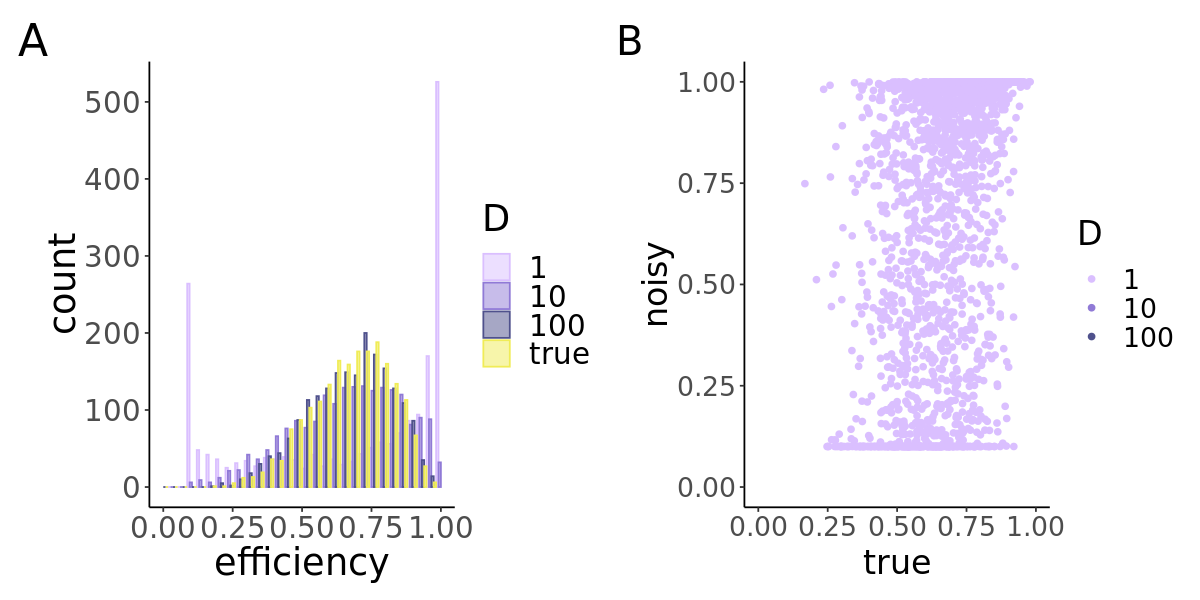

In [11]:
# plot 
options(repr.plot.width=10, repr.plot.height=5)

(est.efficiencies.hist.p | est.efficiencies.scatter.p) + plot_annotation(tag_levels = "A")

In [126]:
png("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/sim_noisy_guide_effs_metrics.png", 
    res = 300, units = "in", width = 10, height = 5)

print(
(est.efficiencies.hist.p | est.efficiencies.scatter.p) + plot_annotation(tag_levels = "A")
)

dev.off()

pdf("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/sim_noisy_guide_effs_metrics.pdf", 
    width = 10, height = 5)

print(
(est.efficiencies.hist.p | est.efficiencies.scatter.p) + plot_annotation(tag_levels = "A")
)

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


png 
  2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


png 
  2

# Plot results of applying GLiMMIRS-base to noisy data
Fitted using perturbation probability

## D=100

In [12]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_D100-noisy_2guides_cont-x1_cont-counts_targeting_pseuodocount_06-20-2024"

alt.coeffs.d100 <- read.csv(file.path(data.dir,"alt_coeffs.csv"))
# null.coeffs.cont.counts.d100.cont.x1 <- read.csv(file.path(data.dir,"null_coeffs.csv"))

## D=10

In [13]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_D10-noisy_2guides_cont-x1_cont-counts_targeting_pseudocount_06-20-2024"

alt.coeffs.d10 <- read.csv(file.path(data.dir,"alt_coeffs.csv"))

## D=1

In [14]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_D1-noisy_2guides_cont-x1_cont-counts_targeting_pseudocount_06-20-2024"

alt.coeffs.d1 <- read.csv(file.path(data.dir,"alt_coeffs.csv"))

## Combine noisy results

In [15]:
alt.coeffs.d100$D <- 100
alt.coeffs.d10$D <- 10
alt.coeffs.d1$D<- 1

alt.coeffs.noisy.plotdf <- do.call(rbind, 
                                   list(alt.coeffs.d100, 
                                        alt.coeffs.d10,
                                       alt.coeffs.d1))

alt.coeffs.noisy.plotdf$D <- as.factor(alt.coeffs.noisy.plotdf$D)

Calculate Pearson correlations between estimated vs. reference coefficients.

In [16]:
test.df <- alt.coeffs.noisy.plotdf %>%
        mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito")))

noisy.eff.pearson.df <- test.df %>% group_by(D, term) %>% 
                                summarise(pearson.r = cor.test(true, estimate, method = "pearson")$estimate,
                                            p_val = cor.test(true, estimate, method = "pearson")$p.value)

noisy.eff.pearson.df

`summarise()` has grouped output by 'D'. You can override using the `.groups`
argument.


D,term,pearson.r,p_val
<fct>,<fct>,<dbl>,<dbl>
1,(Intercept),0.9970442,0.000000e+00
1,guide.eff,0.3706747,9.849968e-34
1,s.score,0.9720201,0.000000e+00
1,g2m.score,0.9808391,0.000000e+00
1,percent.mito,0.9031909,0.000000e+00
10,(Intercept),0.9970707,0.000000e+00
10,guide.eff,0.7807013,5.388042e-206
10,s.score,0.9720916,0.000000e+00
10,g2m.score,0.9815630,0.000000e+00


In [17]:
write.csv(noisy.eff.pearson.df, 
          "/iblm/netapp/data1/jezhou/crisprQTL/revisions_tables/GLiMMIRS-base_noisy_pearson.csv",
          quote = FALSE, row.names = FALSE)

## Plot

Make labeller foar facet grid titles

In [62]:
# Make a modified copy of the original data
noisy.plotdf.mod <- alt.coeffs.noisy.plotdf %>%
            mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>%
              mutate(coeff = recode(term,
                "(Intercept)" = "{beta}[0]",
                "guide.eff" = "{beta}[enhancer]",
                "s.score" = "{beta}[S]",
                "g2m.score" = "{beta}[G2M]",
                "percent.mito" = "{beta}[mito]"
              ))

# order values of D
noisy.plotdf.mod$D <- factor(noisy.plotdf.mod$D,
                            levels=c('100','10','1'))

# change true -> reference
colnames(noisy.plotdf.mod)[which(colnames(noisy.plotdf.mod)=='true')] <- 'reference'

# plot colors 
group.colors <- c(`100` ="#4F518C", `10` = "#907AD6", `1` = "#DABFFF")

### Make a separate plot for every coefficient.

### $\beta_0$

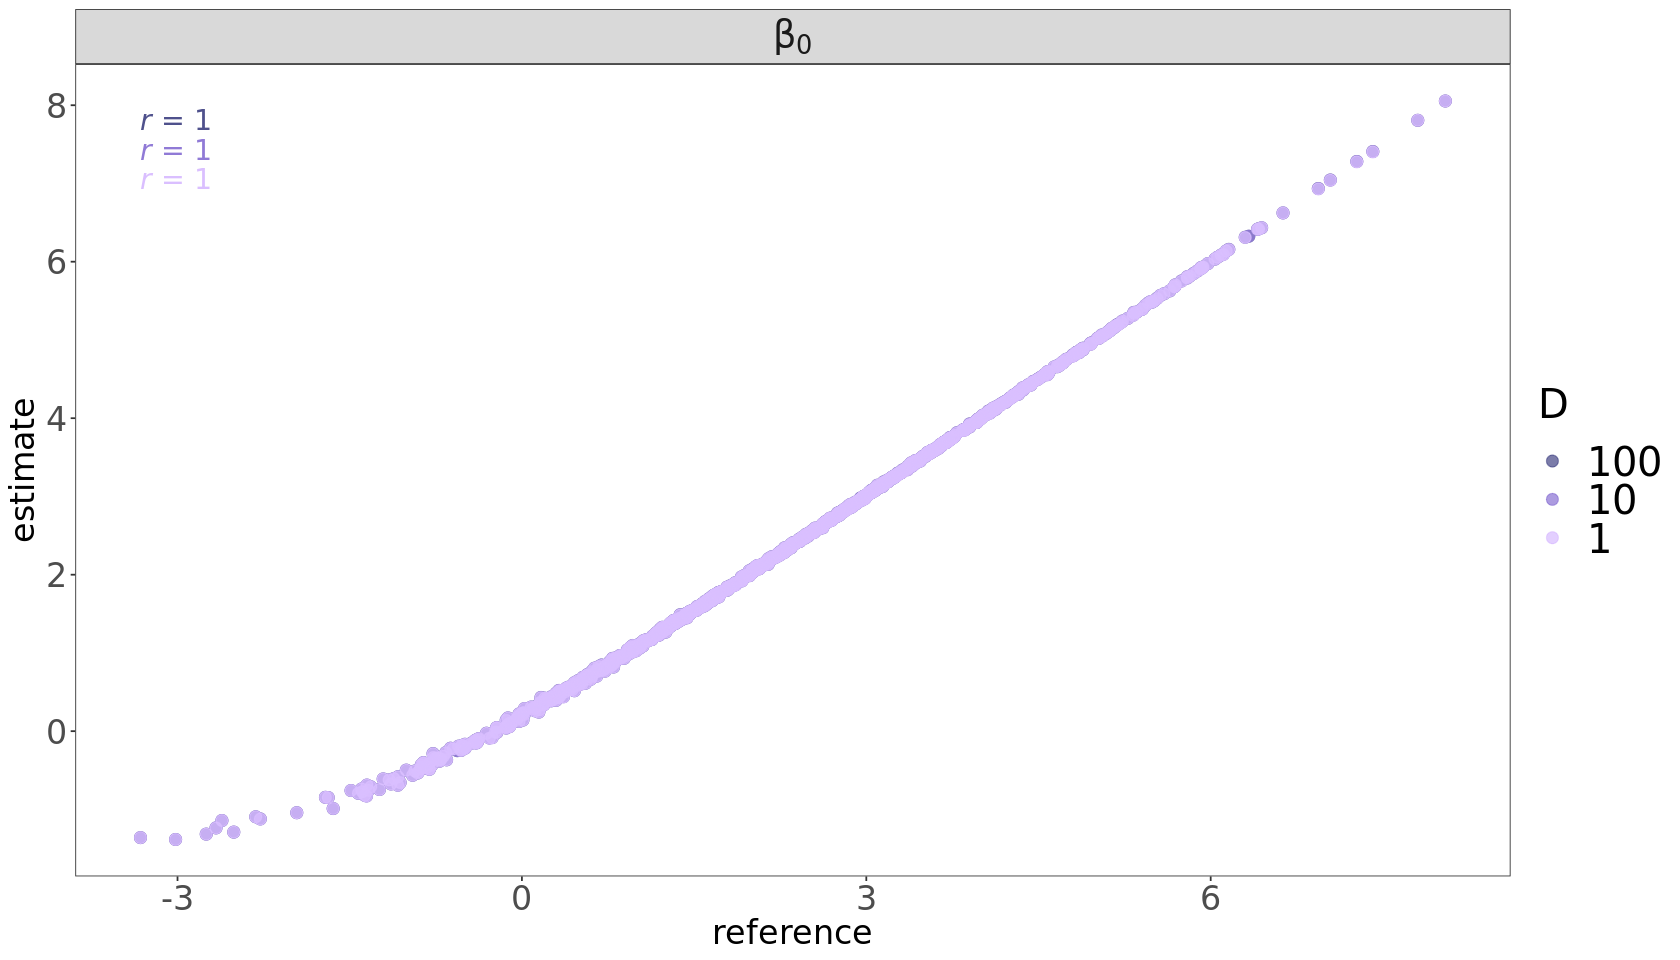

In [116]:
noisy.beta0.p <- noisy.plotdf.mod %>% filter(term == "(Intercept)") %>% 
            ggscatter(x = "reference", y = "estimate", color = "D", alpha = 0.75, size=3
                 ) +
        stat_cor(method = "pearson", aes(color = `D`, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 6) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(strip.text = element_text(size = 22),
                 legend.text = element_text(size = 24),
                 legend.title = element_text(size = 24),
                 axis.text = element_text(size=20),
                 axis.title = element_text(size=20),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors) 


noisy.beta0.p

### $\beta_{enhancer}$

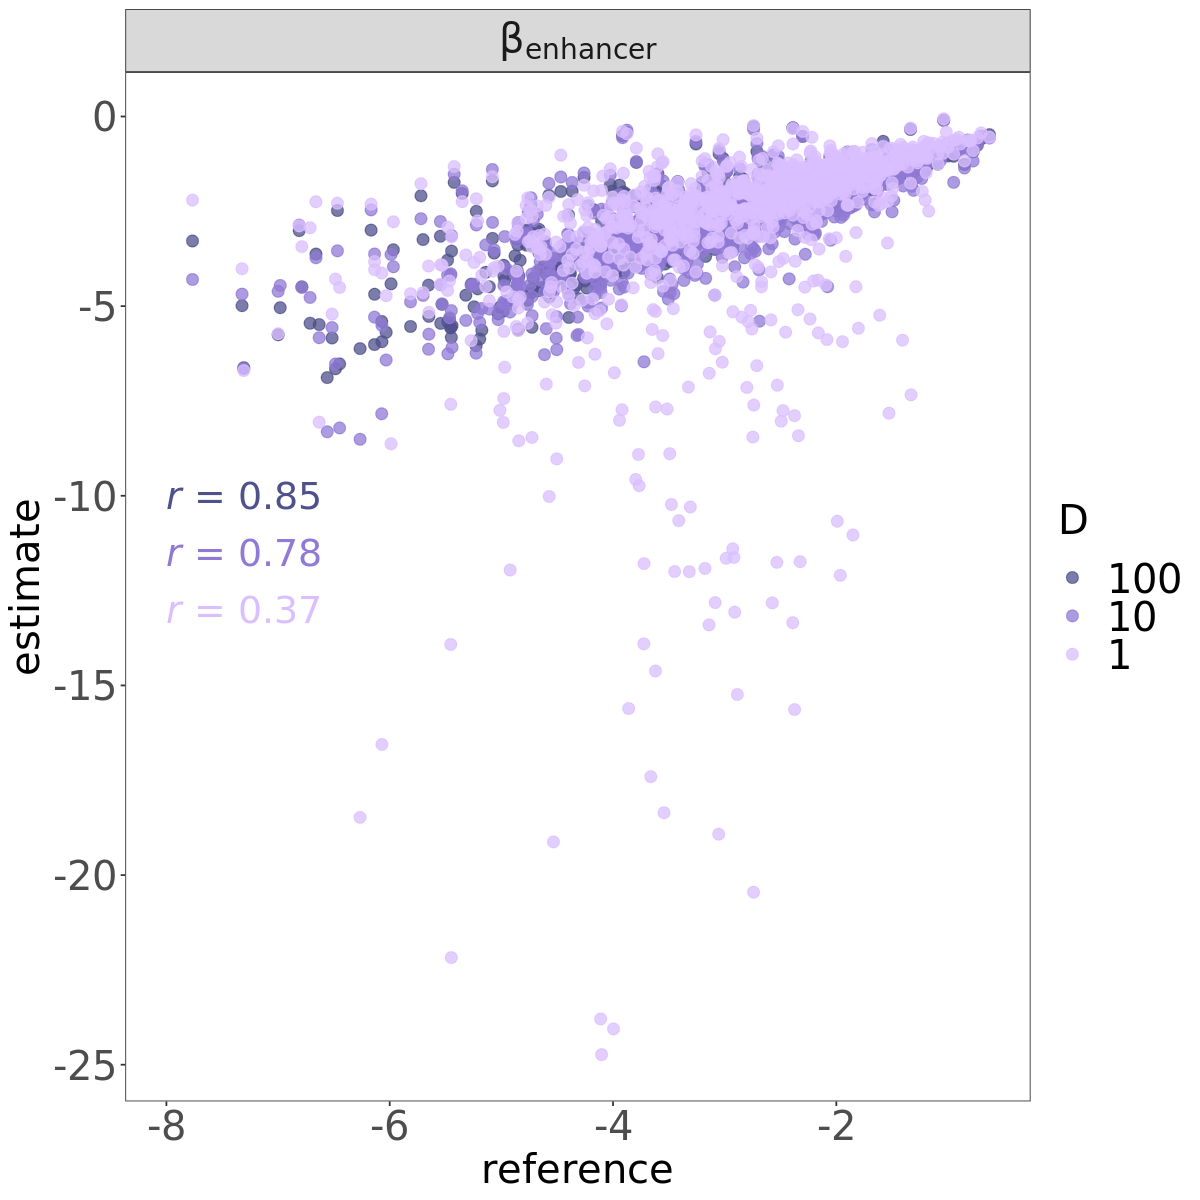

In [110]:
noisy.beta.enh.p <- noisy.plotdf.mod %>% filter(term == "guide.eff") %>%
            ggscatter(x = "reference", y = "estimate", color = "D", alpha = 0.75, size=3
                 ) +
        stat_cor(method = "pearson", aes(color = D, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y = c(-10, -11.5, -13), label.x =-8,
                cor.coef.name = "r",
                 size = 8, data=noisy.plotdf.mod %>% filter(term == "guide.eff")) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(strip.text = element_text(size = 24),
                 legend.text = element_text(size = 24),
                 legend.title = element_text(size = 24),
                 axis.text = element_text(size=24),
                 axis.title = element_text(size=24),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors) 


noisy.beta.enh.p

### $\beta_S, \beta_{G2M}, \beta_{mito}$

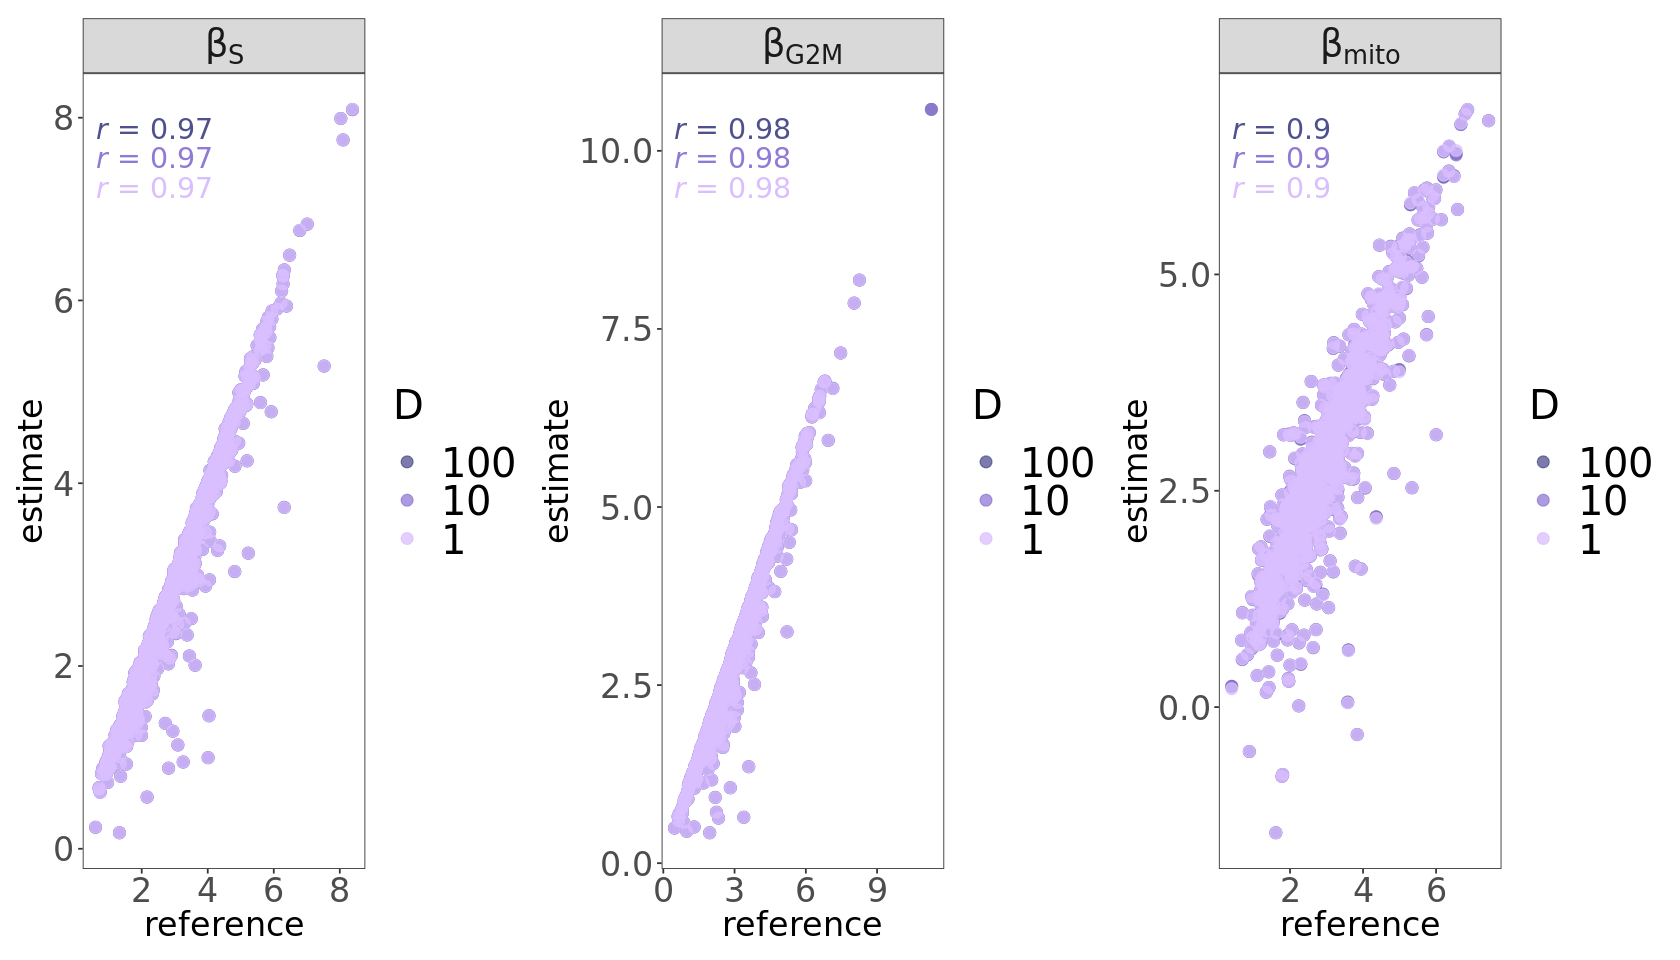

In [115]:
noisy.beta.s.p <- noisy.plotdf.mod %>% filter(term == "s.score") %>% 
            ggscatter(x = "reference", y = "estimate", color = "D", alpha = 0.75, size=3
                 ) +
        stat_cor(method = "pearson", aes(color = D, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 6) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(strip.text = element_text(size = 22),
                 legend.text = element_text(size = 24),
                 legend.title = element_text(size = 24),
                 axis.text = element_text(size=20),
                 axis.title = element_text(size=20),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors) 

noisy.beta.g2m.p <- noisy.plotdf.mod %>% filter(term == "g2m.score") %>% 
            ggscatter(x = "reference", y = "estimate", color = "D", alpha = 0.75, size=3
                 ) +
        stat_cor(method = "pearson", aes(color = D, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 6) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(strip.text = element_text(size = 22),
                 legend.text = element_text(size = 24),
                 legend.title = element_text(size = 24),
                 axis.text = element_text(size=20),
                 axis.title = element_text(size=20),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors) 

noisy.beta.mito.p <- noisy.plotdf.mod %>% filter(term == "percent.mito") %>% 
            ggscatter(x = "reference", y = "estimate", color = "D", alpha = 0.75, size=3
                 ) +
        stat_cor(method = "pearson", aes(color = D, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 6) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(strip.text = element_text(size = 22),
                 legend.text = element_text(size =24),
                 legend.title = element_text(size = 24),
                 axis.text = element_text(size=20),
                 axis.title = element_text(size=20),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors) 



noisy.beta.s.p | noisy.beta.g2m.p | noisy.beta.mito.p

### Stitch together with patchwork

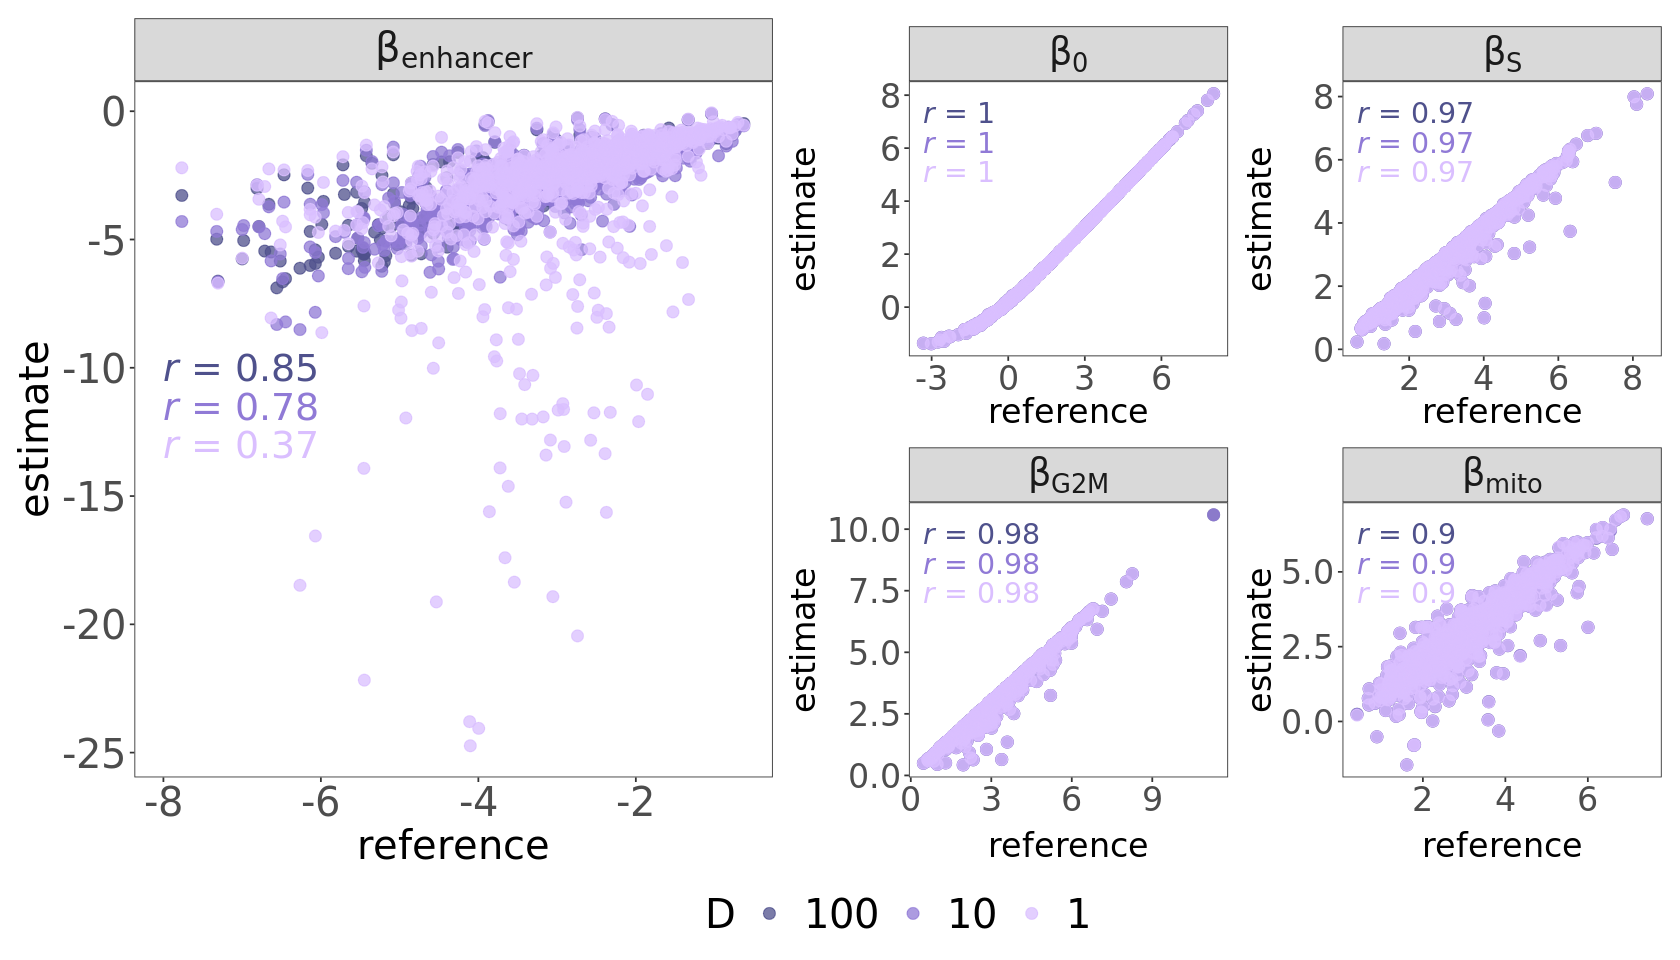

In [117]:
options(repr.plot.width=14, repr.plot.height=8)

design <- "
AAAABBCC
AAAADDEE
"

noisy.beta.enh.p + noisy.beta0.p + noisy.beta.s.p + noisy.beta.g2m.p + noisy.beta.mito.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")


In [118]:
png("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/alt_coeffs_scatterplot_cont-counts_cont-x1_noisy_eff_PSEUDOCOUNT_pearson.png", 
    res = 300, units = "in", width = 14, height = 8)

print(
noisy.beta.enh.p + noisy.beta0.p + noisy.beta.s.p + noisy.beta.g2m.p + noisy.beta.mito.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")
)

dev.off()

pdf("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/alt_coeffs_scatterplot_cont-counts_cont-x1_noisy_eff_PSEUDOCOUNT_pearson.pdf", 
    width = 14, height = 8)

print(
noisy.beta.enh.p + noisy.beta0.p + noisy.beta.s.p + noisy.beta.g2m.p + noisy.beta.mito.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")
)

dev.off()

png 
  2

png 
  2